# k-Nearest-Neighbour classifiers
Here we use the k-nearest-neighbor method on the converted data from the descriptive_analysis.ipynb.
As reference we use dataMining_R_8_ml.Rmd (./uebung/knn_uebung/) from the lecture.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [2]:
data = pd.read_csv('./data/converted_test_2020_06_03_16-14-12.csv')
train = pd.read_csv('./data/converted_train_2020_06_03_16-14-12.csv')

In [3]:
# Encode Request_Weekday column
encoder = preprocessing.LabelEncoder()
data['Request_Weekday']=encoder.fit_transform(data['Request_Weekday'])
train['Request_Weekday']=encoder.fit_transform(train['Request_Weekday'])

# Encode route abb column
data['route_abb']=encoder.fit_transform(data['route_abb'])
train['route_abb']=encoder.fit_transform(train['route_abb'])

# Encode Request_AM_PM column
data['Request_AM_PM']=encoder.fit_transform(data['Request_AM_PM'])
train['Request_AM_PM']=encoder.fit_transform(train['Request_AM_PM'])

# Encode currency_in_eur column
data['price_in_eur']=encoder.fit_transform(data['price_in_eur'])
train['price_in_eur']=encoder.fit_transform(train['price_in_eur'])

# Encode Duration Time
data['Duration_Time']=encoder.fit_transform(data['Duration_Time'])
train['Duration_Time']=encoder.fit_transform(train['Duration_Time'])

# Encode min_future_price
train['min_future_price_in_eur']=encoder.fit_transform(train['min_future_price_in_eur'])

In [4]:
# Drop columns we do not need from data
data_dropped = data.drop(columns=['Request_Date', 'Flight_Date', 'flight_unique_id', 'flight_number', 'Currency', 'Price'])
data_dropped = data_dropped.loc[:, ~data_dropped.columns.str.contains('^Unnamed')]

# Drop columns we do not need from train
train_dropped = train.drop(columns=['Request_Date', 'Flight_Date', 'flight_unique_id', 'flight_number', 'Currency', 'Price', 'min_future_price'])
train_dropped = train_dropped.loc[:, ~train_dropped.columns.str.contains('^Unnamed')]

In [5]:
print(data_dropped.head())
print(train_dropped.head())

   Duration_Time  Departure_hour  route_abb  price_in_eur  Request_Weekday  \
0              0              18          3           118                2   
1              1              22          3           180                2   
2              2               6          3           102                2   
3              0               6          3           118                2   
4              5              10          3           180                2   

   Request_AM_PM  
0              0  
1              0  
2              0  
3              1  
4              0  
   Duration_Time  Departure_hour  route_abb  price_in_eur  \
0             10              19          3           602   
1              5              19          3           620   
2              1              19          3           620   
3             12              21          2           450   
4              7              21          2           586   

   min_future_price_in_eur  Request_Weekday  Reque

In [9]:
# Generate test and target / Figure out which features to drop. 'min_future_price_in_eur' needs to be dropped!
X = train_dropped.drop(columns=['min_future_price_in_eur'])
y = train_dropped['min_future_price_in_eur'].values
X

,Duration_Time,price_in_eur,Request_Weekday
0,10,602,1
1,5,620,1
2,1,620,5
3,12,450,1
4,7,586,1
...,...,...,...
83006,453,10,4
83007,448,10,0
83008,443,10,0
83009,438,10,2


In [10]:
# Split dataset into train and test data (might want to try random_state=0 to randomize each calculation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)
print(X_train.shape)
print(y_train.shape)

(49806, 3)
(49806,)


In [11]:
# We try to find the best value for k.
k_list = np.arange(1,20)
train_accuracy = np.empty(len(k_list))
test_accuracy = np.empty(len(k_list))

for i,k in enumerate(k_list):
    knn_test = KNeighborsClassifier(n_neighbors=k)
    knn_test.fit(X_train, y_train)
    train_accuracy[i] = knn_test.score(X_train, y_train)
    test_accuracy[i] = knn_test.score(X_test, y_test) 

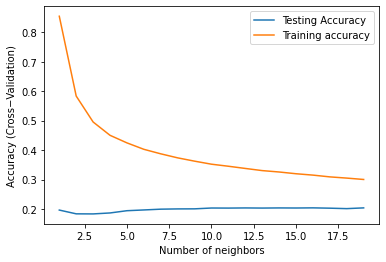

In [12]:
#Generate plot
plt.plot(k_list, test_accuracy, label='Testing Accuracy')
plt.plot(k_list, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy (Cross−Validation)')
plt.show()

In [13]:
knn = KNeighborsClassifier(n_neighbors=15)
#Fit the model
knn.fit(X_train,y_train)
#Get accuracy
knn.score(X_test,y_test)

0.2038548411383828